# Example: Generating Input Arrays for PyRayHF

This example demonstrates how to generate the required PyRayHF input arrays using **PyIRI**.

PyIRI is used to compute the IRI electron density profile and the IGRF magnetic-field parameters along a vertical column at a specified location and time.

The function `generate_input_1D()` returns a dictionary with the following fields:

**out_data : dict**

- `alt` — vertical grid (km)  
- `den` — electron density (m⁻³)  
- `bmag` — magnetic-field strength (T)  
- `bpsi` — magnetic-field angle relative to vertical (degrees)  

- `F2` — PyIRI output dictionary for the F2 region at (tlon, tlat)  
- `F1` — PyIRI output dictionary for the F1 region at (tlon, tlat)  
- `E` — PyIRI output dictionary for the E region at (tlon, tlat)  
- `Es` — PyIRI output dictionary for the Es region at (tlon, tlat)

- `year` — year used in the PyIRI run  
- `month` — month used in the PyIRI run  
- `day` — day of month used in the PyIRI run  
- `UT` — universal time (hours)  
- `F107` — F10.7 index (SFU)

- `tlat` — latitude of the transmitter (degrees)  
- `tlon` — longitude of the transmitter (degrees)


Nigh-Time Example

In [1]:
# Import libraries
import PyRayHF
import matplotlib.pyplot as plt
import numpy as np


# Select the day and Universal Time of interest
year = 2025
month = 9
day = 1
UT = 0

# F10.7 index for the selected day
F107 = 204.

# Define geographic location (longitude, latitude in degrees)
lon = 0.
lat = 4.5

# Create an array of altitudes (km)
aalt = np.arange(80., 700., 1.)

# Save to file
save_path = './Example_Input_Night.p'

# Generate 1D Data
input_example = PyRayHF.library.generate_input_1D(year, month, day, UT, lat, lon, aalt, F107, save_path=save_path)


# Generate array of frequencies used by a vertical ionosonde in MHz.
f_min = 0.1
f_max = 17.5
df = 0.1
ionosonde_frequency = np.arange(f_min, f_max, df)

Plot 1-D Data

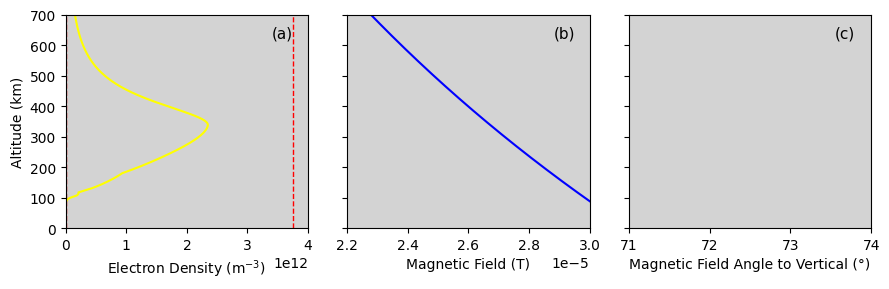

In [5]:
# Plot the input arrays
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(9, 3)


# Plot electron density profile
ax_plot = ax[0]
ax_plot.set_ylim([0, 600])
ax_plot.set_xlim([0, 4e12])
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Altitude (km)')
ax_plot.set_xlabel('Electron Density (m$^{-3}$)')
ax_plot.plot(input_example['den'], input_example['alt'], c='yellow',
             label='EDP')
min_d = PyRayHF.library.freq2den(np.min(ionosonde_frequency) * 1e6)
max_d = PyRayHF.library.freq2den(np.max(ionosonde_frequency) * 1e6)
ax_plot.axvline(x=min_d, color='r', linestyle='--', linewidth=1, label='Instrument Freq Range')
ax_plot.axvline(x=max_d, color='r', linestyle='--', linewidth=1)
ax_plot.text(0.85, 0.95, '(a)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')


# Plot magnetic field magnitude
ax_plot = ax[1]
ax_plot.set_ylim([0, 600])
ax_plot.set_xlim([2.2e-5, 3e-5])
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Magnetic Field (T)')
ax_plot.plot(input_example['bmag'], input_example['alt'], c='blue',
             label='B')
ax_plot.text(0.85, 0.95, '(b)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')


# Plot angle between magnetic field and vertical
ax_plot = ax[2]
ax_plot.set_ylim([0, 700])
ax_plot.set_xlim([71, 74])
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Magnetic Field Angle to Vertical (°)')
ax_plot.plot(input_example['bpsi'], input_example['alt'], c='purple',
             label='$\\Psi$')
ax_plot.text(0.85, 0.95, '(c)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')
plt.tight_layout()
plt.savefig('../figures/Input_Arrays_Night.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

Day-Time Example

In [4]:
# Define geographic location (longitude, latitude in degrees)
lon = -150
lat = 4.5

# Create an array of altitudes (km)
aalt = np.arange(80., 700., 1.)

# Save to file
save_path = './Example_Input_Day.p'

# Generate 1D Data
input_example = PyRayHF.library.generate_input_1D(year, month, day, UT, lat, lon, aalt, F107, save_path=save_path)

Plot 1-D Data

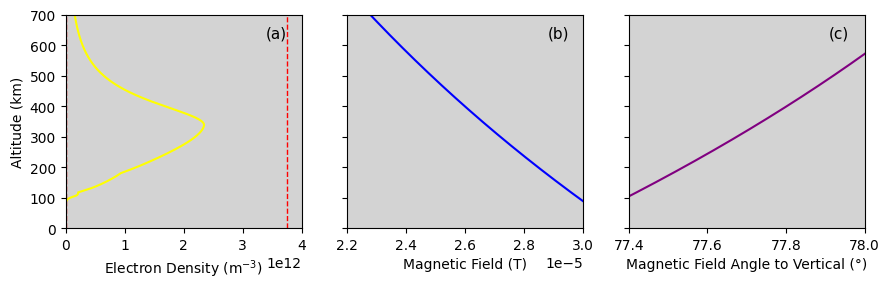

In [6]:
# Plot the input arrays
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(9, 3)


# Plot electron density profile
ax_plot = ax[0]
ax_plot.set_ylim([0, 600])
ax_plot.set_xlim([0, 4e12])
ax_plot.set_facecolor("lightgray")
ax_plot.set_ylabel('Altitude (km)')
ax_plot.set_xlabel('Electron Density (m$^{-3}$)')
ax_plot.plot(input_example['den'], input_example['alt'], c='yellow',
             label='EDP')
min_d = PyRayHF.library.freq2den(np.min(ionosonde_frequency) * 1e6)
max_d = PyRayHF.library.freq2den(np.max(ionosonde_frequency) * 1e6)
ax_plot.axvline(x=min_d, color='r', linestyle='--', linewidth=1, label='Instrument Freq Range')
ax_plot.axvline(x=max_d, color='r', linestyle='--', linewidth=1)
ax_plot.text(0.85, 0.95, '(a)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')


# Plot magnetic field magnitude
ax_plot = ax[1]
ax_plot.set_ylim([0, 600])
ax_plot.set_xlim([2.2e-5, 3e-5])
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Magnetic Field (T)')
ax_plot.plot(input_example['bmag'], input_example['alt'], c='blue',
             label='B')
ax_plot.text(0.85, 0.95, '(b)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')


# Plot angle between magnetic field and vertical
ax_plot = ax[2]
ax_plot.set_ylim([0, 700])
ax_plot.set_xlim([77.4, 78.0])
ax_plot.set_facecolor("lightgray")
ax_plot.set_xlabel('Magnetic Field Angle to Vertical (°)')
ax_plot.plot(input_example['bpsi'], input_example['alt'], c='purple',
             label='$\\Psi$')
ax_plot.text(0.85, 0.95, '(c)', transform=ax_plot.transAxes, fontsize=11, ha='left', va='top', c='black')
plt.tight_layout()
plt.savefig('../figures/Input_Arrays_Day.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()